# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [1]:
# Load Python Libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, List, Tuple, Optional

from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%config InlineBackend.figure_format = 'retina'

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [2]:
# load data, cleaned, not normalized, with features
data = pd.read_csv("../datasets/AAPL_2009-2010_6m_features_1d.csv")
state_features = ["Date", "Close", "BB_upper", "BB_lower"]
data = data[state_features]

idx_close = 0
idx_bb_upper = 1
idx_bb_lower = 2
data.head()

,Date,Close,BB_upper,BB_lower
0,2009-04-30,4.493929,4.570118,4.055596
1,2009-05-01,4.544286,4.578017,4.099590
2,2009-05-04,4.716786,4.642685,4.092351
3,2009-05-05,4.716786,4.699974,4.083704
4,2009-05-06,4.732143,4.750376,4.083481


# 2. Train / Test Split
Now that we have loaded our cleaned price dataset, we are ready to feed the data into our model. With this in mind, we select Close as our singular training feature, and split the data ito train, valid and test data (75/15/15 split)

In [3]:
# split dataset df into train (80%) and test (20%) datasets
training_rows = int(len(data.index) * 0.8)
train_df = data.loc[:training_rows].set_index("Date")
test_df = data.loc[training_rows:].set_index("Date")

In [4]:
print(train_df.head())
print(test_df.head())

               Close  BB_upper  BB_lower
Date                                    
2009-04-30  4.493929  4.570118  4.055596
2009-05-01  4.544286  4.578017  4.099590
2009-05-04  4.716786  4.642685  4.092351
2009-05-05  4.716786  4.699974  4.083704
2009-05-06  4.732143  4.750376  4.083481
               Close  BB_upper  BB_lower
Date                                    
2009-11-11  7.249286  7.449068  6.564432
2009-11-12  7.213929  7.469366  6.582349
2009-11-13  7.301786  7.489785  6.620501
2009-11-16  7.379643  7.522641  6.647538
2009-11-17  7.392857  7.558544  6.641063


In [5]:
# convert train and test dfs to np arrays with dtype=float
X_train = train_df.values.astype(float)
X_test = test_df.values.astype(float)
# print the shape of X_train to remind yourself how many examples and features are in the dataset
X_train.shape

(137, 3)

# 3. Define the Agent
Now that our data is ready to use, we can define the Reinforcement Learning Agent.

### Define the DQN Model
The first step in defining our agent is the Deep Q-Network model definition. 
- we are creating a model sequential model with four layers. The first three layers have output shape of 64, 32, and 8, respectively, and a RELU activation. 
- The output layer has an output shape of the size of our action space (buy, sell, hold), and a linear activation.

In [6]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size=3, seed=42):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action (default=3 for buy, sell, hold)
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.Q = nn.Sequential(
            nn.Linear(state_size, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, action_size),  # Linear activation by default
        )

    def forward(self, state):
        """Build a network that maps state -> action values."""
        actions = self.Q(state)
        return actions



### Define Experience Replay Buffer
The Experience Replay Buffer is a key component of our agent implementation. It consists of a deque data structure with a fixed maximum length (buffer_size) that stores experiences as tuples of (state, action, reward, next_state, done). 

The buffer serves two main purposes:
1. Storing and sampling experiences for training - Random batches of experiences are drawn from the buffer to train the agent
2. Maintaining recent experiences - The last n experiences (where n is the batch size) are kept to calculate target Q-values for the current state during training


In [7]:
from collections import namedtuple


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            batch_size (int): size of each training batch
            buffer_size (int): maximum size of buffer
            seed (int): random seed
        """
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple(
            "Experience",
            field_names=["state", "action", "reward", "next_state", "done"],
        )
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def _to_tensor(self, data, dtype=torch.float):
        """Convert numpy array to tensor with specified dtype and device in one operation"""
        return torch.from_numpy(np.vstack(data)).to(device=device, dtype=dtype)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""

        experiences = random.sample(self.memory, k=self.batch_size)
        experiences = [e for e in experiences if e is not None]
        states, actions, rewards, next_states, dones = zip(*experiences)

        states = self._to_tensor(states)
        actions = self._to_tensor(actions, dtype=torch.long)
        rewards = self._to_tensor(rewards)
        next_states = self._to_tensor(next_states)
        dones = self._to_tensor(dones, dtype=torch.uint8)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Define Agent Class

The Agent class implements a Deep Q-Learning agent that interacts with a trading environment. This implementation features a Double DQN (Deep Q-Network) architecture with experience replay for stable learning.

#### Main Methods

1. **step(state, action, reward, next_state, done)**
   - Stores experience in replay buffer
   - Triggers learning every `update_step` steps
   - Returns loss value when learning occurs

2. **select_action(state, epsilon)**
   - Implements epsilon-greedy policy for action selection
   - In test mode: Always selects best action
   - In training mode: Balances exploration and exploitation

3. **learn(experiences)**
   - Updates Q-Network parameters using sampled experiences
   - Implements Double DQN learning algorithm:
     1. Computes TD targets using target network
     2. Computes current Q-values using local network
     3. Updates networks using MSE loss
     4. Performs soft update of target network

4. **Network Updates**
   - `soft_update()`: Gradually updates target network (θ_target = α×θ + (1-α)×θ_target)
   - `hard_update()`: Directly copies parameters from local to target network

5. **Model Persistence**
   - `save(filename)`: Saves model parameters to file
   - `load(filename)`: Loads model parameters from file


In [8]:
class Agent:
    """Interacts with and learns from the environment."""

    def __init__(
        self,
        env,
        test_mode=False,
        buffer_size=int(1e5),
        batch_size=64,
        gamma=0.99,
        alpha=1e-3,
        lr=5e-4,
        update_step=4,
        seed=42,
        device=None,
    ):
        """Initialize an Agent object.

        Key Features:
            - State space: Concatenated window of features (window_size * num_features)
            - Action space: 3 discrete actions (0=hold, 1=buy, 2=sell)
            - Experience replay: Stores and samples past experiences for stable learning
            - Target network: Updated softly for stable training

        Params
        ======
            buffer_size (int): Maximum size of experience replay buffer (default: 1e5)
            batch_size (int): Size of each training batch (default: 64)
            gamma (float): Discount factor for future rewards (default: 0.99)
            alpha (float): Soft update interpolation parameter (default: 1e-3)
            lr (float): Learning rate for optimizer (default: 5e-4)
            update_step (int): Frequency of network updates (default: 4)
            test_mode (bool): Flag for switching between training and testing behavior
        """
        self.seed = random.seed(seed)
        self.test_mode = test_mode
        self.device = device

        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.lr = lr
        self.gamma = gamma
        self.alpha = alpha
        self.update_step = update_step

        self.state_size = env.state_size  # window_size * num_features
        self.action_size = 3

        # Q-Network
        self.Q = QNetwork(self.state_size, self.action_size, seed).to(device)
        self.Q_target = QNetwork(self.state_size, self.action_size, seed).to(device)
        self.optimizer = optim.Adam(self.Q.parameters(), lr=self.lr)

        # Replay memory
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size, seed)
        # Initialize time step (for updating every update step)
        self.t_step = 0

    def __repr__(self):
        return (
            f"Q Network Arch: {self.Q}\n"
            f"State space size: {self.state_size}\n"
            f"Action space size: {self.action_size}\n"
            f"Current Memory size: {len(self.memory)}"
        )

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every update_step time steps.
        self.t_step = (self.t_step + 1) % self.update_step
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                loss = self.learn(experiences)
                return loss

    def select_action(self, state, epsilon=0.0):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.Q.eval()
        with torch.no_grad():
            actions = self.Q(state)

        if self.test_mode:
            return np.argmax(actions.cpu().data.numpy())

        self.Q.train()
        # Epsilon-greedy action selection
        if random.random() <= epsilon:
            return random.choice(np.arange(self.action_size))
        else:
            return np.argmax(actions.cpu().data.numpy())

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        self.optimizer.zero_grad()

        # get experiences
        states, actions, rewards, next_states, dones = experiences

        # compute td targets using target network
        with torch.no_grad():
            Q_targets_next = torch.max(
                self.Q_target(next_states), dim=-1, keepdim=True
            )[0]
            Q_targets = rewards + (1 - dones) * self.gamma * Q_targets_next

        # compute curr values using local network
        Q_expected = torch.gather(self.Q(states), dim=-1, index=actions)

        # compute mean squared loss using td error
        loss = F.mse_loss(Q_expected, Q_targets)
        loss.backward()

        # update local network parameters
        self.optimizer.step()

        # update target network parameters
        self.soft_update()

        return loss

    def soft_update(self):
        """Soft update model parameters.
        θ_target = alpha*θ + (1 - alpha)*θ_target
        =>
        θ_target = θ_target + alpha*(θ - θ_target)

        Params
        ======
            Q (PyTorch model): weights will be copied from
            Q_target (PyTorch model): weights will be copied to
            alpha (float): interpolation parameter
        """
        for target_param, local_param in zip(
            self.Q_target.parameters(), self.Q.parameters()
        ):
            target_param.data.copy_(
                target_param.data + self.alpha * (local_param.data - target_param.data)
            )

    def hard_update(self):
        """Hard update: θ_target = θ"""
        for target_param, local_param in zip(
            self.Q_target.parameters(), self.Q.parameters()
        ):
            target_param.data.copy_(local_param.data)

    def save(self, filename):
        """Save model parameters."""
        torch.save(self.Q.state_dict(), filename)

    def load(self, filename):
        """Load model parameters."""
        checkpoint = torch.load(filename)
        self.Q.load_state_dict(checkpoint)

# 4. Define Environment

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Environment:
    """
    Trading environment for reinforcement learning agent.

    Attributes:
    -----------
    data : pd.DataFrame
        DataFrame containing trading data and indicators
    features : np.ndarray
        NumPy array of feature values
    feature_columns : List[str]
        List of feature column names
    feature_map : Dict[str, int]
        Mapping of feature names to array indices
    n_features : int
        Number of features in the data
    n_samples : int
        Total number of time steps in the data
    current_step : int
        Current time step in the episode
    inventory : List[float]
        List of purchase prices for held positions
    total_profit : float
        Cumulative profit from all trades
    window_size : int
        Number of time steps in state observation
    state_size : int
        Size of the state vector (window_size * n_features)
    action_size : int
        Number of possible actions (3: hold, buy, sell)
    """

    def __init__(
        self, data: pd.DataFrame, window_size: int = 10, verbose=False
    ) -> None:
        """
        Initialize the trading environment.

        Parameters:
        -----------
        data : pd.DataFrame
            DataFrame containing trading data and indicators
        window_size : int, default=10
            Number of time steps to include in state observation
        """
        self.verbose = verbose

        # Data initialization
        self.data = data
        self.features = self.data.values
        self.feature_columns = self.data.columns.tolist()
        self.feature_map = self._create_feature_mapping(self.feature_columns)

        # Environment dimensions
        self.n_features = len(self.feature_columns)
        self.n_samples = len(self.data)

        # Trading state variables
        self.current_step: Optional[int] = None
        self.inventory: Optional[List[float]] = None
        self.total_profit: Optional[float] = None

        # Environment configuration
        self.window_size = window_size
        self.state_size = self.window_size * self.n_features
        self.action_size = 3  # hold (0), buy (1), sell (2)

        self.total_winners = 0.0
        self.total_losers = 0.0
        self.states_buy = []
        self.states_sell = []

        # Initialize environment state
        self.reset()

    def reset(self) -> np.ndarray:
        """
        Reset the environment to initial state.

        Returns:
        --------
        np.ndarray
            Initial state observation
        """
        self.current_step = 0
        self.inventory = []
        self.total_profit = 0.0
        self.total_winners = 0.0
        self.total_losers = 0.0
        self.states_buy = []
        self.states_sell = []
        return self._get_state(self.current_step)

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, Dict]:
        """
        Execute trading action and return new state, reward, and info.

        Parameters:
        -----------
        action : int
            Trading action (0: hold, 1: buy, 2: sell)

        Returns:
        --------
        next_state : np.ndarray
            Next state observation
        reward : float
            Reward for the action (profit from trade if any)
        done : bool
            Whether episode is finished
        info : dict
            Additional information including:
            - action: Executed action type
            - trade_profit: Profit from trade (if sold)
            - total_profit: Cumulative profit
            - inventory: Number of held positions
        """
        reward = 0.0
        info = {}

        current_price = self._get_current_price()

        if action == 1:  # Buy
            self.inventory.append(current_price)
            self.states_buy.append(self.current_step)
            info["action"] = "buy"
            info["buy_price"] = current_price.item()
            if self.verbose:
                print(f"Buy: {self.format_price(current_price.item())}")

        elif action == 2 and len(self.inventory) > 0:  # Sell
            bought_price = self.inventory.pop(0)
            trade_profit = current_price - bought_price
            reward = max(trade_profit, 0)  # Only positive rewards
            self.total_profit += trade_profit.item()

            # Track trade statistics
            if trade_profit >= 0:
                self.total_winners += trade_profit.item()
            else:
                self.total_losers += trade_profit.item()

            self.states_sell.append(self.current_step)

            # Update info dictionary
            info["action"] = "sell"
            info["sell_price"] = current_price.item()
            info["bought_price"] = bought_price.item()
            info["trade_profit"] = trade_profit.item()

            if self.verbose:
                print(
                    f"Sell: {self.format_price(current_price.item())} | "
                    f"Profit: {self.format_price(trade_profit.item())}"
                )
        else:
            info["action"] = "hold"

        # Update state
        self.current_step += 1
        done = 1 if self.current_step >= self.n_samples - 1 else 0

        # Get next state observation
        next_state = self._get_state(self.current_step)

        # Add additional info
        info.update(
            {
                "current_step": self.current_step,
                "current_price": current_price.item(),
                "total_profit": self.total_profit,
                "inventory_size": len(self.inventory),
                "total_winners": self.total_winners,
                "total_losers": self.total_losers,
                "states_buy": self.states_buy.copy(),
                "states_sell": self.states_sell.copy(),
            }
        )

        if self.inventory:
            info["inventory_prices"] = self.inventory.copy()
            info["avg_buy_price"] = np.mean(self.inventory).item()

        return next_state, reward, done, info

    def get_feature_value(self, feature_name: str, step: Optional[int] = None) -> float:
        """
        Get the value of a specific feature at a given step.

        Parameters:
        -----------
        feature_name : str
            Name of the feature to retrieve
        step : int, optional
            Step at which to get the feature value. If None, uses current_step

        Returns:
        --------
        float
            Value of the requested feature

        Raises:
        -------
        KeyError
            If requested feature is not found in the data
        """
        if step is None:
            step = self.current_step

        try:
            feature_idx = self.feature_map[feature_name]
            return self.features[step][feature_idx]
        except KeyError:
            raise KeyError(
                f"Feature '{feature_name}' not found. "
                f"Available features: {list(self.feature_map.keys())}"
            )

    def _get_current_price(self) -> float:
        """
        Get the current close price using the feature mapping.

        Returns:
        --------
        float
            Current closing price

        Raises:
        -------
        KeyError
            If 'Close' price column is not found in the data
        """
        try:
            close_idx = self.feature_map["Close"]
            return self.features[self.current_step][close_idx]
        except KeyError:
            raise KeyError(
                "'Close' price column not found in feature map. "
                f"Available features: {list(self.feature_map.keys())}"
            )

    def _create_feature_mapping(self, columns: List[str]) -> Dict[str, int]:
        """
        Create a mapping dictionary from feature names to their indices.

        Parameters:
        -----------
        columns : List[str]
            List of column names from the DataFrame

        Returns:
        --------
        Dict[str, int]
            Dictionary mapping feature names to their indices
        """
        # Create mapping of feature names to column indices
        feature_map = {col: idx for idx, col in enumerate(columns)}

        # Validate presence of required features
        if "Close" not in feature_map:
            raise ValueError(
                "Required 'Close' price column not found in data. "
                f"Available columns: {columns}"
            )

        return feature_map

    def _get_state(self, t: int) -> np.ndarray:
        """
        Get the state observation at time t.

        The state consists of price/indicator differences between consecutive
        time steps within the observation window.

        Parameters:
        -----------
        t : int
            Current time step

        Returns:
        --------
        np.ndarray
            Flattened array of feature differences in the observation window
        """
        n = self.window_size + 1
        d = t - n

        if d >= 0:
            # Get actual historical window
            window = self.features[d:t]
        else:
            # Pad with initial values for early steps
            window = np.array([self.features[0]] * n)

        # Calculate differences between consecutive time steps
        differences = sigmoid(window[1:] - window[:-1])

        # Flatten and return as 1D array
        return np.array([differences]).flatten()

    def format_price(self, price: float) -> str:
        """Format price value to currency string."""
        return f"${price:,.2f}"

In [11]:
def plot_behavior(env, states_buy, states_sell, total_reward, train=True):
    """
    Plot trading behavior with price data and buy/sell signals

    Parameters:
    -----------
    env : TradingEnv
        Trading environment containing the price data and indicators
    states_buy : list
        List of indices where buy actions occurred
    states_sell : list
        List of indices where sell actions occurred
    total_reward : float
        Total reward/profit from the episode
    train : bool
        Whether this is training or test data (affects x-axis ticks)
    """
    fig = plt.figure(figsize=(15, 5))

    # Get data from environment
    close_data = env.data["Close"].values
    bb_upper_data = env.data["BB_upper"].values
    bb_lower_data = env.data["BB_lower"].values

    # Plot price and Bollinger Bands
    plt.plot(close_data, color="k", lw=2.0, label="Close Price")
    plt.plot(bb_upper_data, color="b", lw=2.0, label="Bollinger Bands")
    plt.plot(bb_lower_data, color="b", lw=2.0)

    # Plot buy/sell signals
    if states_buy:
        plt.plot(
            states_buy,
            close_data[states_buy],
            "^",
            markersize=10,
            color="g",
            label="Buy Signal",
        )
    if states_sell:
        plt.plot(
            states_sell,
            close_data[states_sell],
            "v",
            markersize=10,
            color="r",
            label="Sell Signal",
        )

    # Set title and labels
    plt.title(f"Trading Behavior (Total Reward: ${total_reward:.2f})")
    plt.xlabel("Time Step")
    plt.ylabel("Price ($)")
    plt.legend()

    # Set x-axis ticks based on data length
    data_len = len(close_data)
    if train:
        tick_interval = max(1, data_len // 15)
    else:
        tick_interval = max(1, data_len // 2)

    plt.xticks(range(0, data_len, tick_interval), rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_losses(losses, title):
    """Plot the training losses"""
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Training Loss')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
env = Environment(train_df, window_size=1, verbose=False)

In [13]:
agent = Agent(
    env,
    test_mode=False,
    buffer_size=1000,
    batch_size=32,
    gamma=0.95,
    alpha=1e-3,
    lr=0.001,
    update_step=4,
    seed=42,
    device=device,
)
agent

Q Network Arch: QNetwork(
  (Q): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)
State space size: 3
Action space size: 3
Current Memory size: 0

# 5. Train the Agent
Now that our agent is defined, we are ready to train it.

In [19]:
def dqn(
    env,
    agent,
    n_episodes=2,
    window=10,
    max_t=1000,
    epsilon=1.0,
    eps_min=0.01,
    eps_decay=0.995,
):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        epsilon (float): starting value of epsilon, for epsilon-greedy action selection
        eps_min (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    # list containing scores and losses from each episode
    scores = []
    losses = []
    max_avg_score = float('-inf')

    for i_episode in range(1, n_episodes + 1):
        # get init state
        state = env.reset()
        episode_score = 0
        episode_losses = []  # Reset episode losses

        # run each episode
        for t in range(max_t):
            action = agent.select_action(state, epsilon)
            next_state, reward, done, info = env.step(action)
            loss = agent.step(state, action, reward, next_state, done)
            
            # Collect loss if not None
            if loss is not None:
                episode_losses.append(loss.item())
                
            state = next_state
            episode_score += reward

            if done:
                scores.append(episode_score)
                # Append mean loss for this episode
                if episode_losses:
                    losses.append(np.mean(episode_losses))
                
                print(
                    f"Episode {i_episode} | "
                    f"Total Profit: {info['total_profit']} | "
                    f"Total Winners: {info['total_winners']} | "
                    f"Total Losers: {info['total_losers']} | "
                    f"Average Loss: {losses[-1] if losses else 0}"
                )
                plot_behavior(
                    env,
                    info["states_buy"],
                    info["states_sell"],
                    info["total_profit"],
                )
                plot_losses(losses, f'Episode {i_episode} DQN model loss')
                break

        # Update epsilon
        epsilon = max(eps_min, eps_decay * epsilon)

        # Print episode stats
        if len(scores) > window:
            avg_score = np.mean(scores[-window:])
            if avg_score > max_avg_score:
                max_avg_score = avg_score
                agent.save("checkpoint.pth")

        if i_episode % window == 0:
            print(
                "\rEpisode {}/{} | Max Average Score: {:.2f}".format(
                    i_episode, n_episodes, max_avg_score
                ),
            )

        agent.save("checkpoint.pth")
    return scores, losses



Episode 1 | Total Profit: 0.0 | Total Winners: 0.0 | Total Losers: 0.0 | Average Loss: 0.017706892401393916


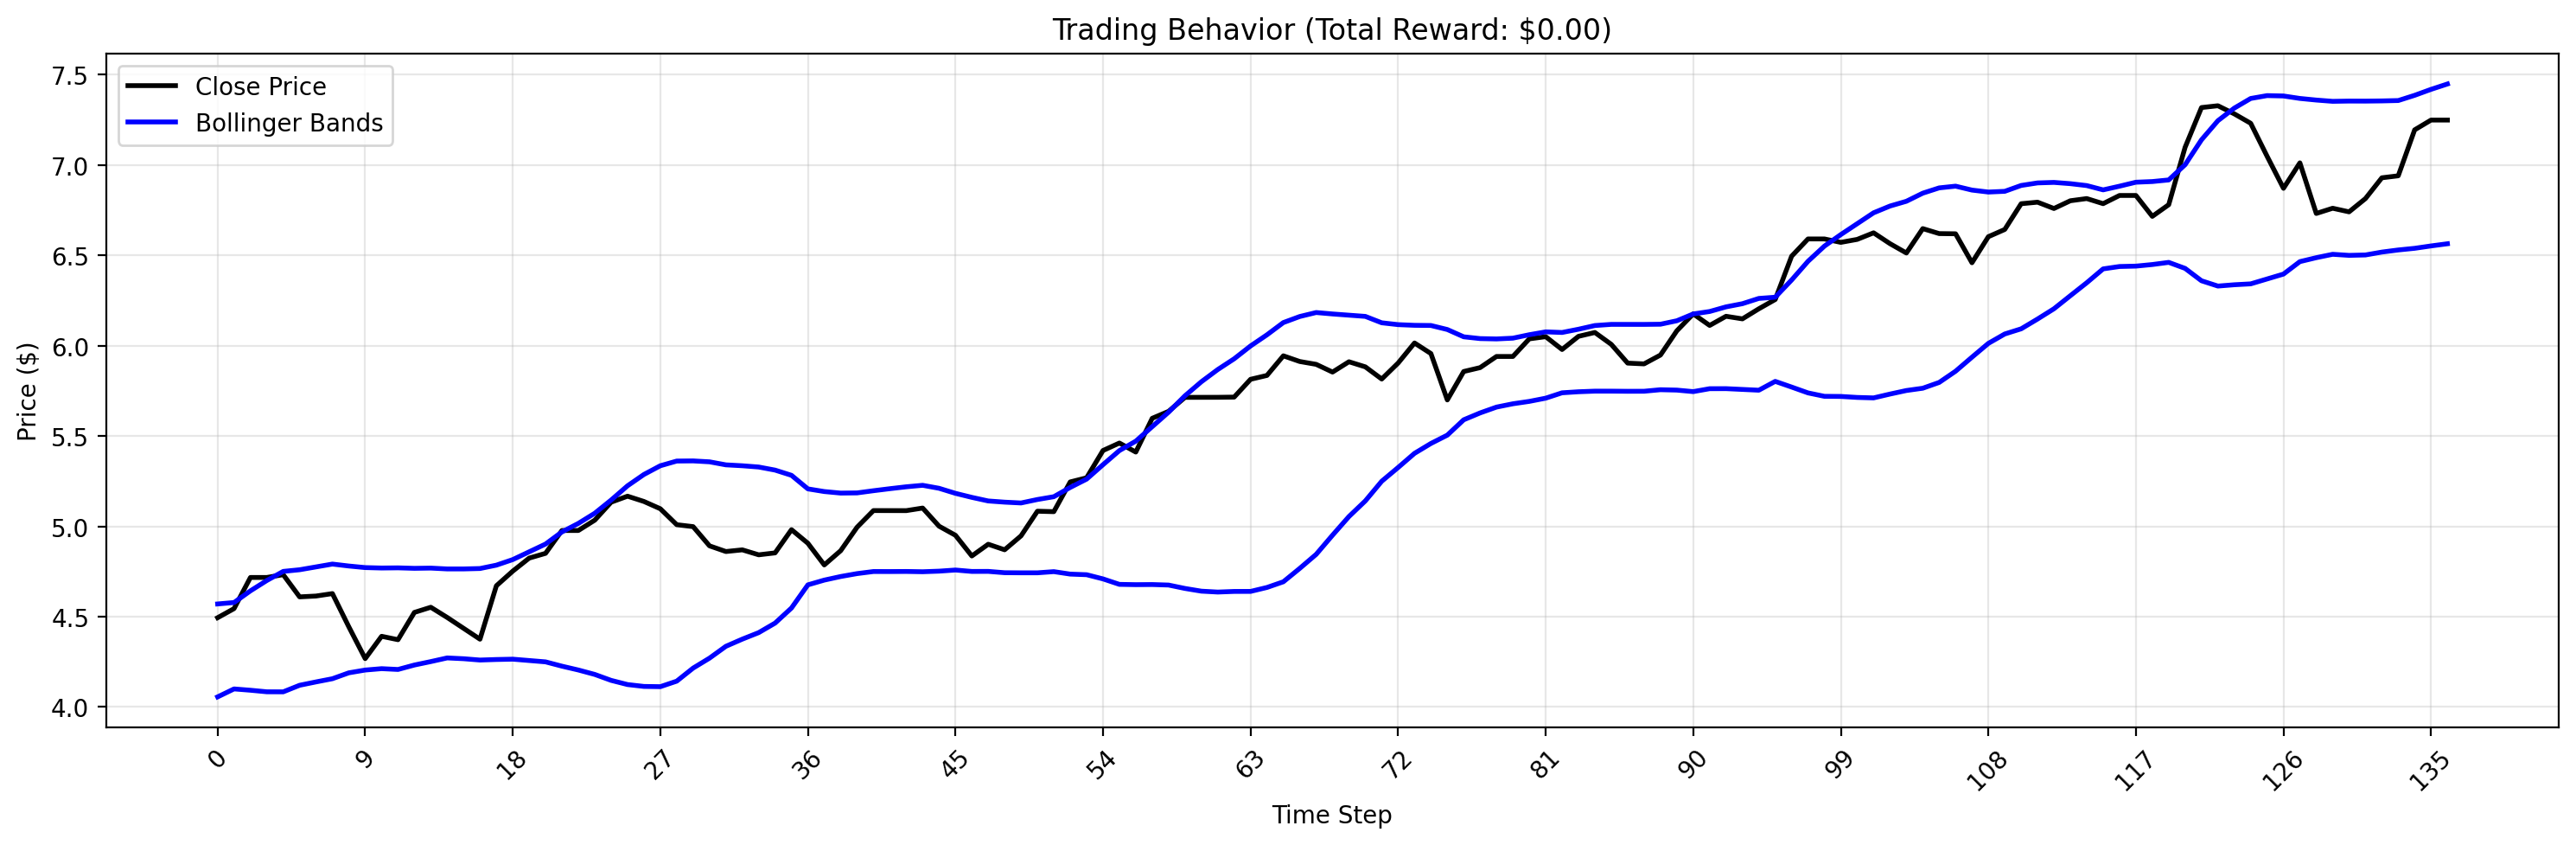

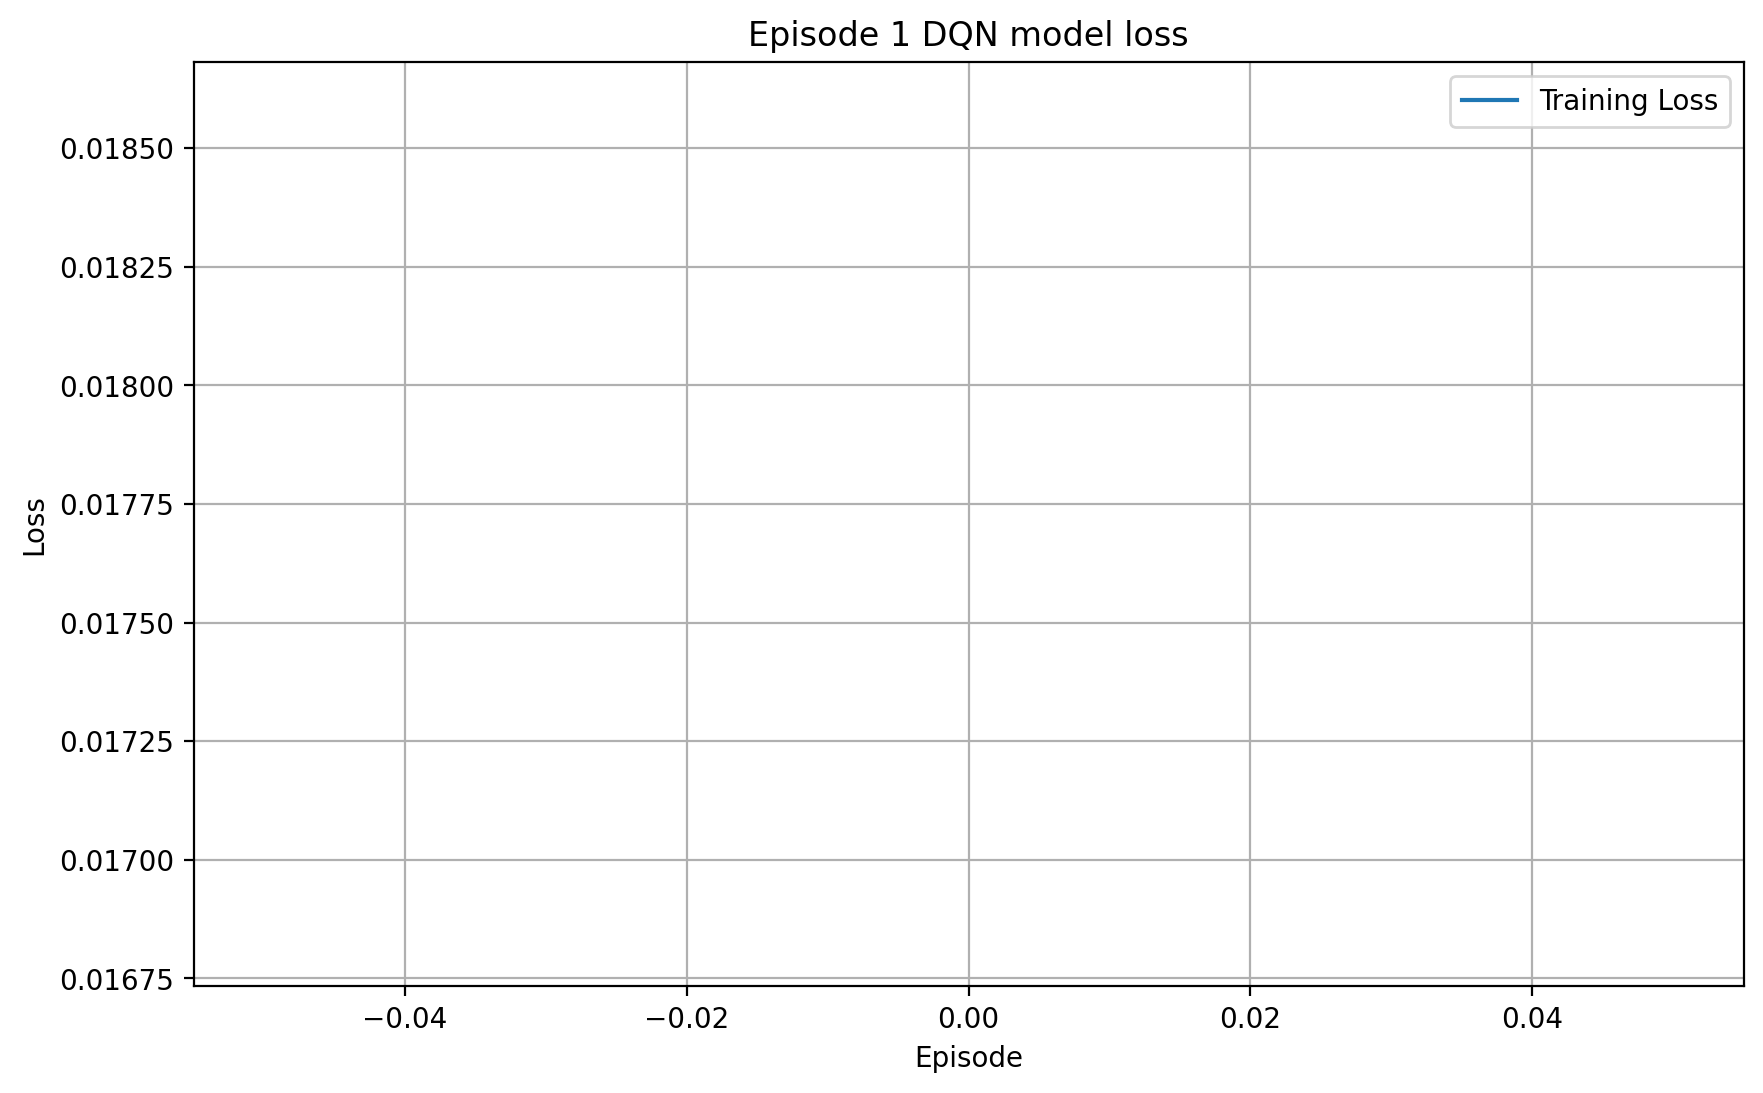

Episode 1/3 | Max Average Score: -inf
Episode 2 | Total Profit: 0.0 | Total Winners: 0.0 | Total Losers: 0.0 | Average Loss: 0.002330830385798275


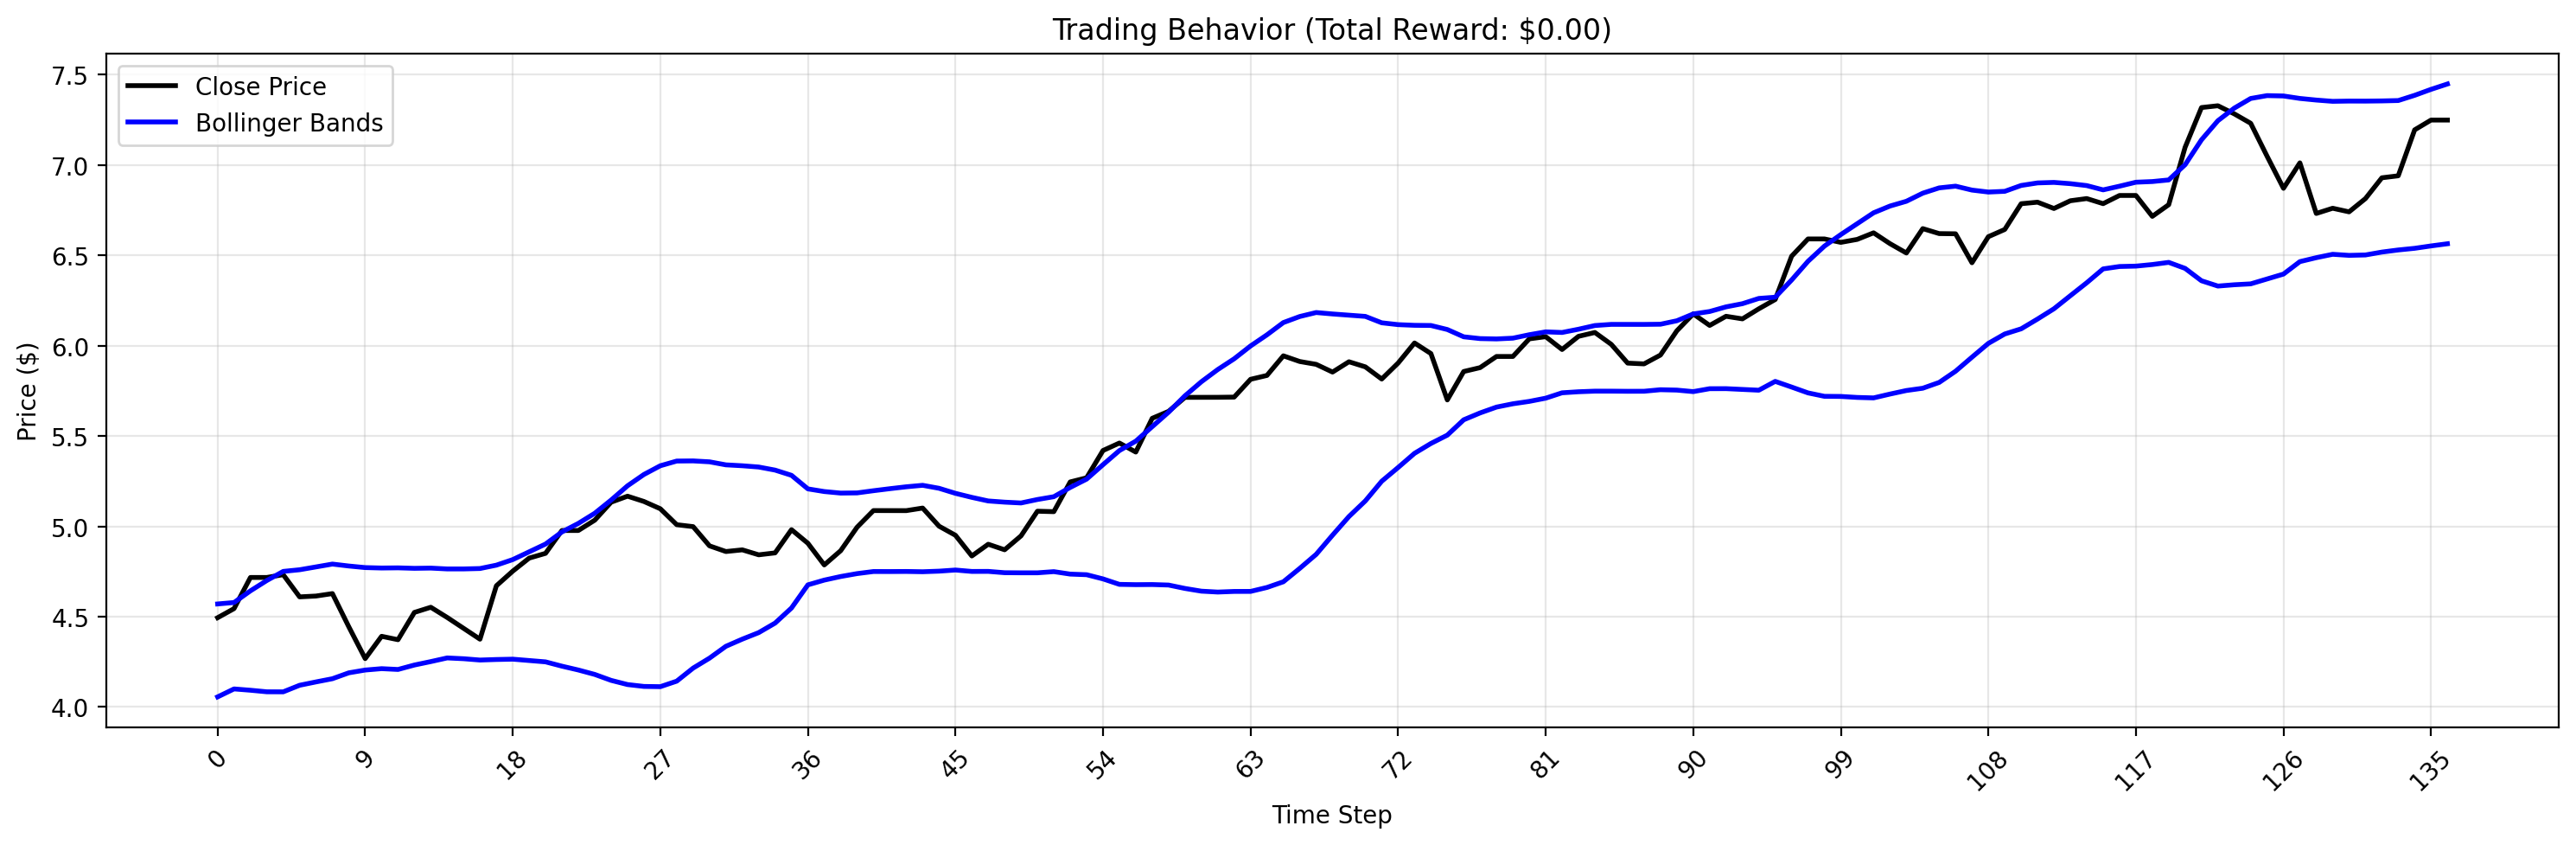

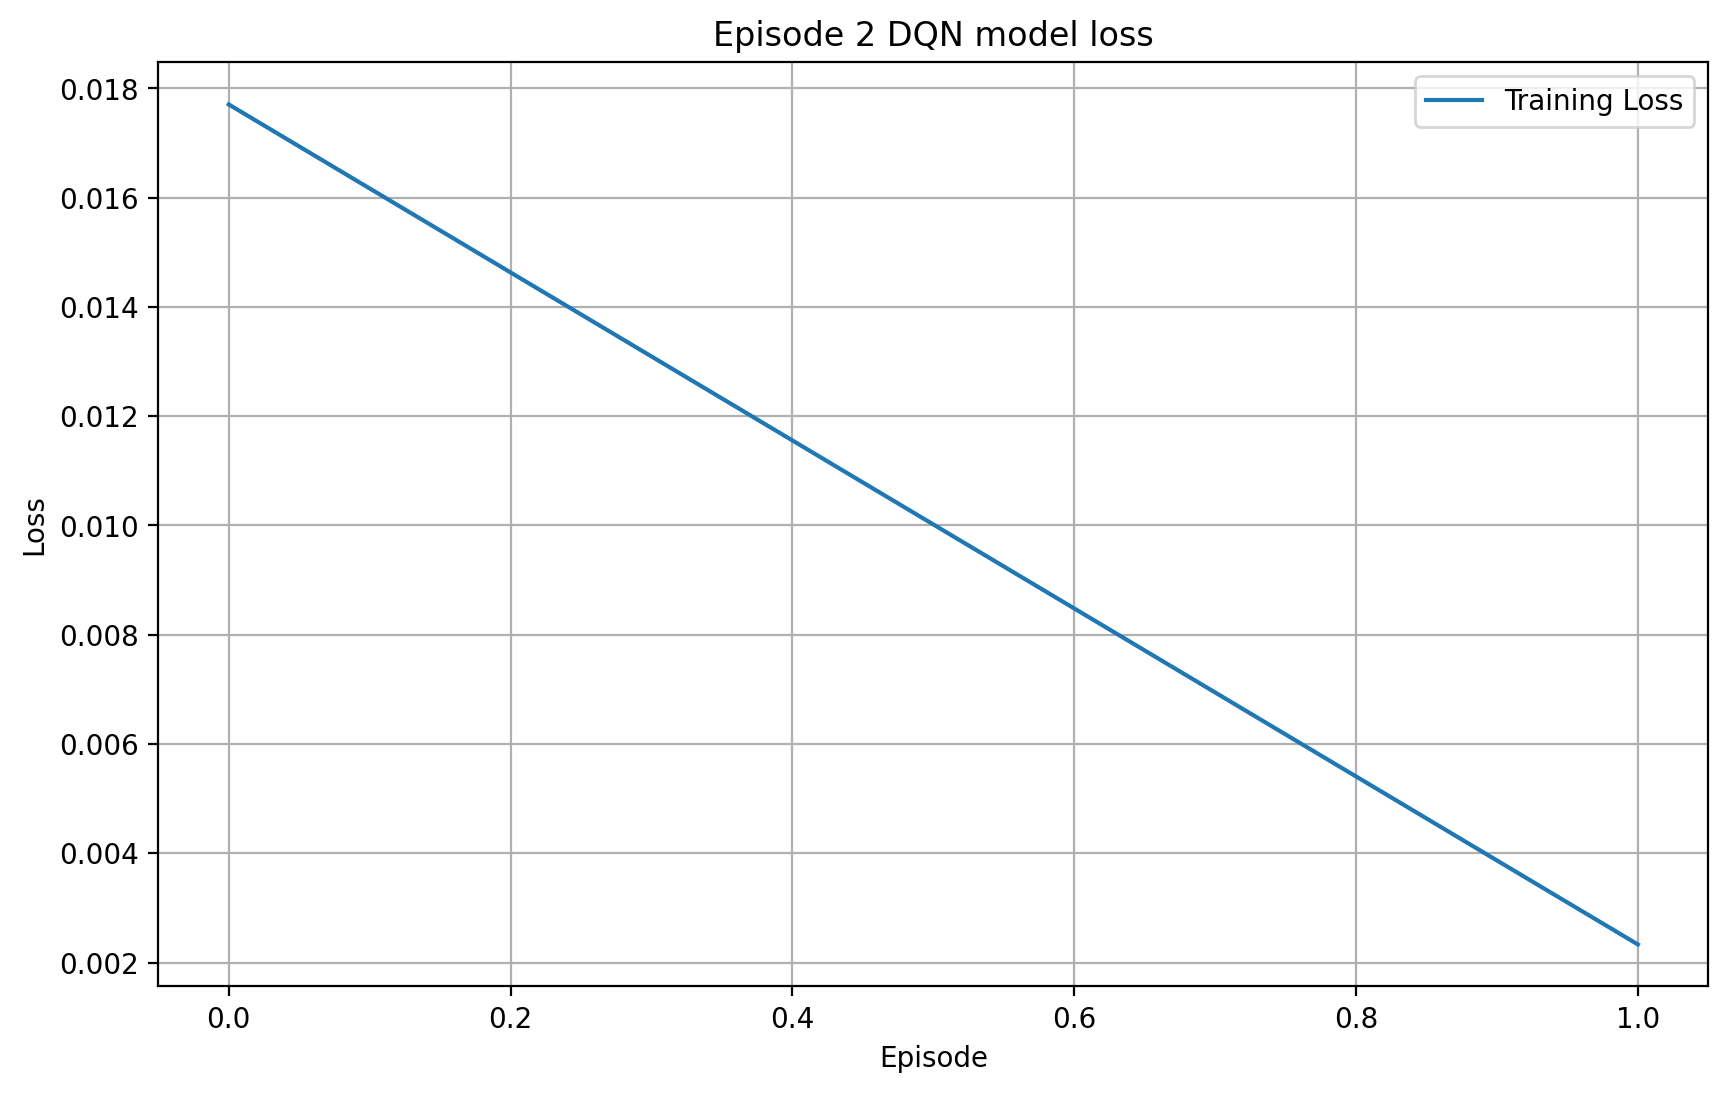

Episode 2/3 | Max Average Score: 0.00
Episode 3 | Total Profit: 9.114640712738037 | Total Winners: 9.142854690551758 | Total Losers: -0.028213977813720703 | Average Loss: 0.0019338411503962132


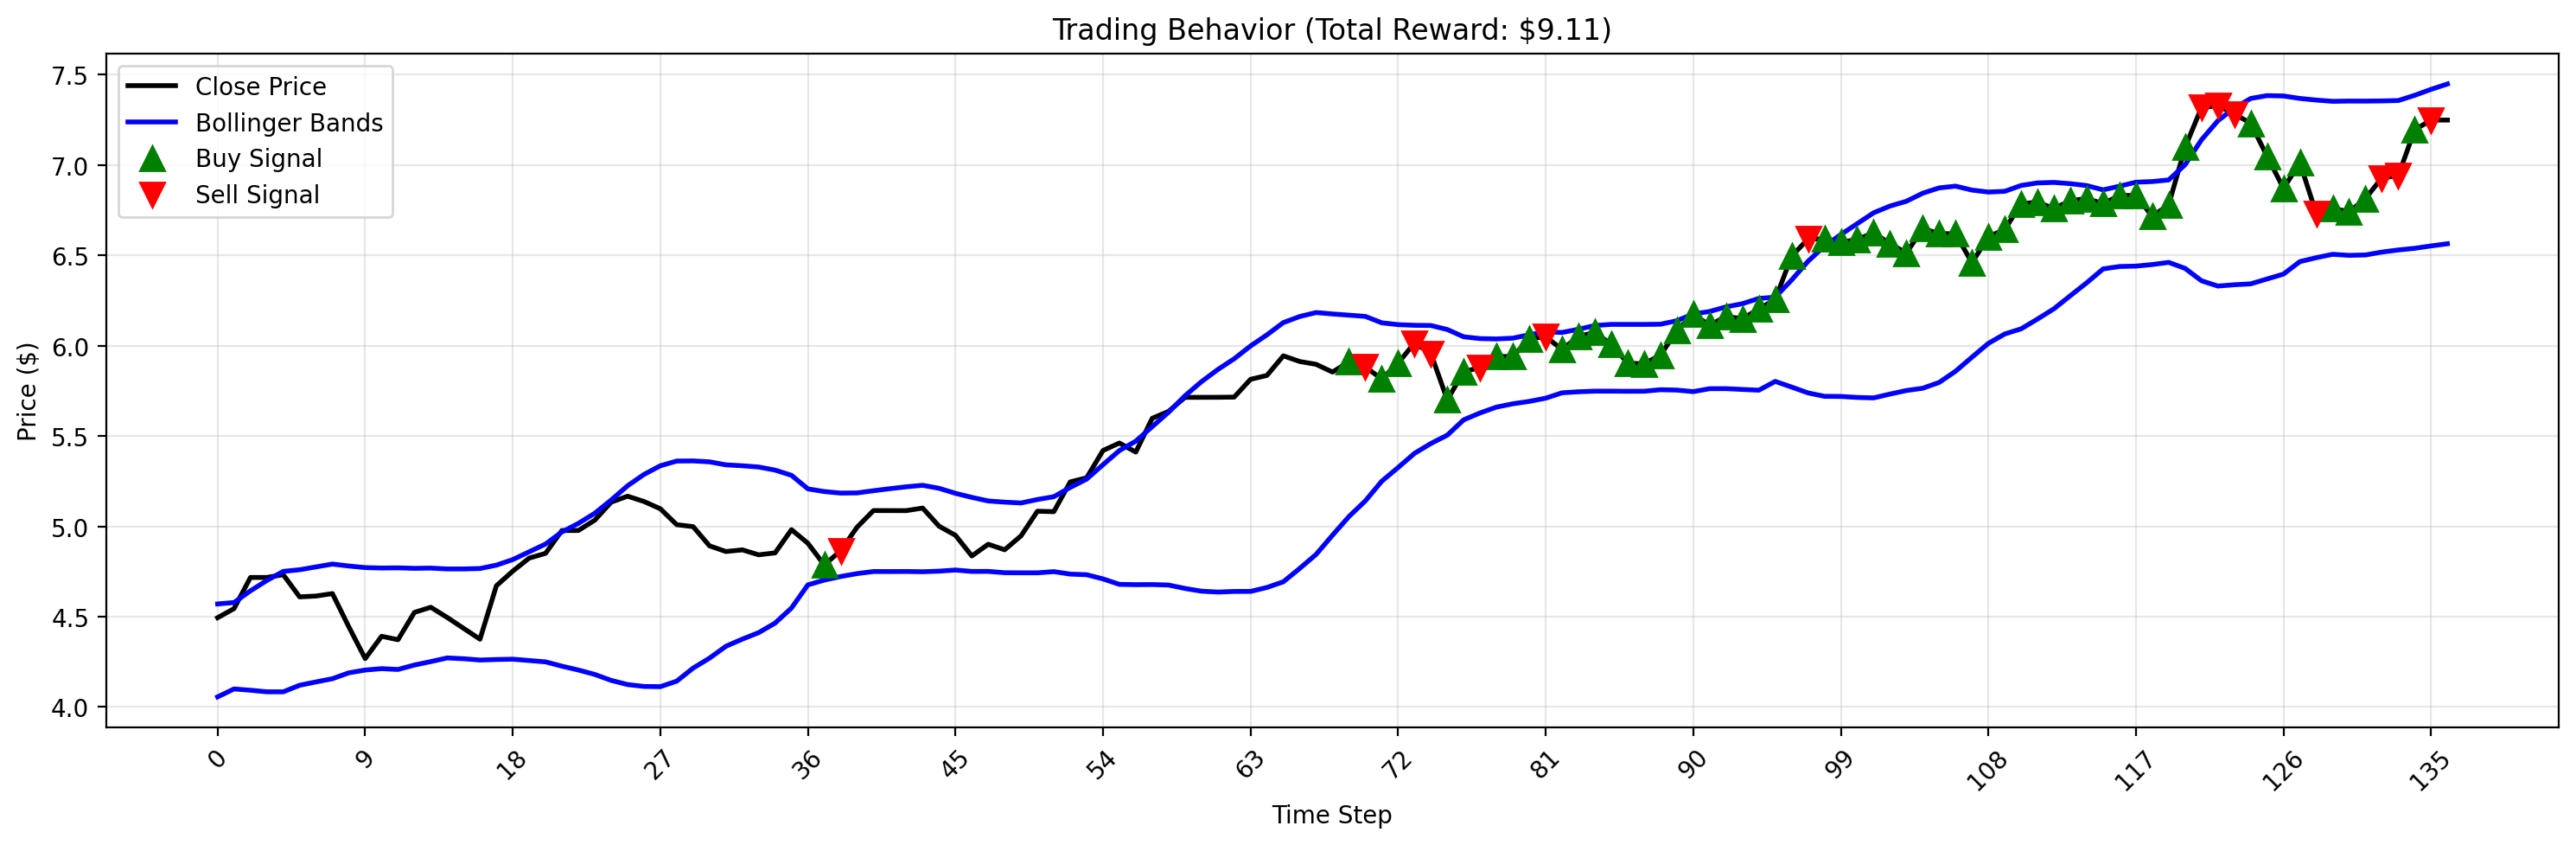

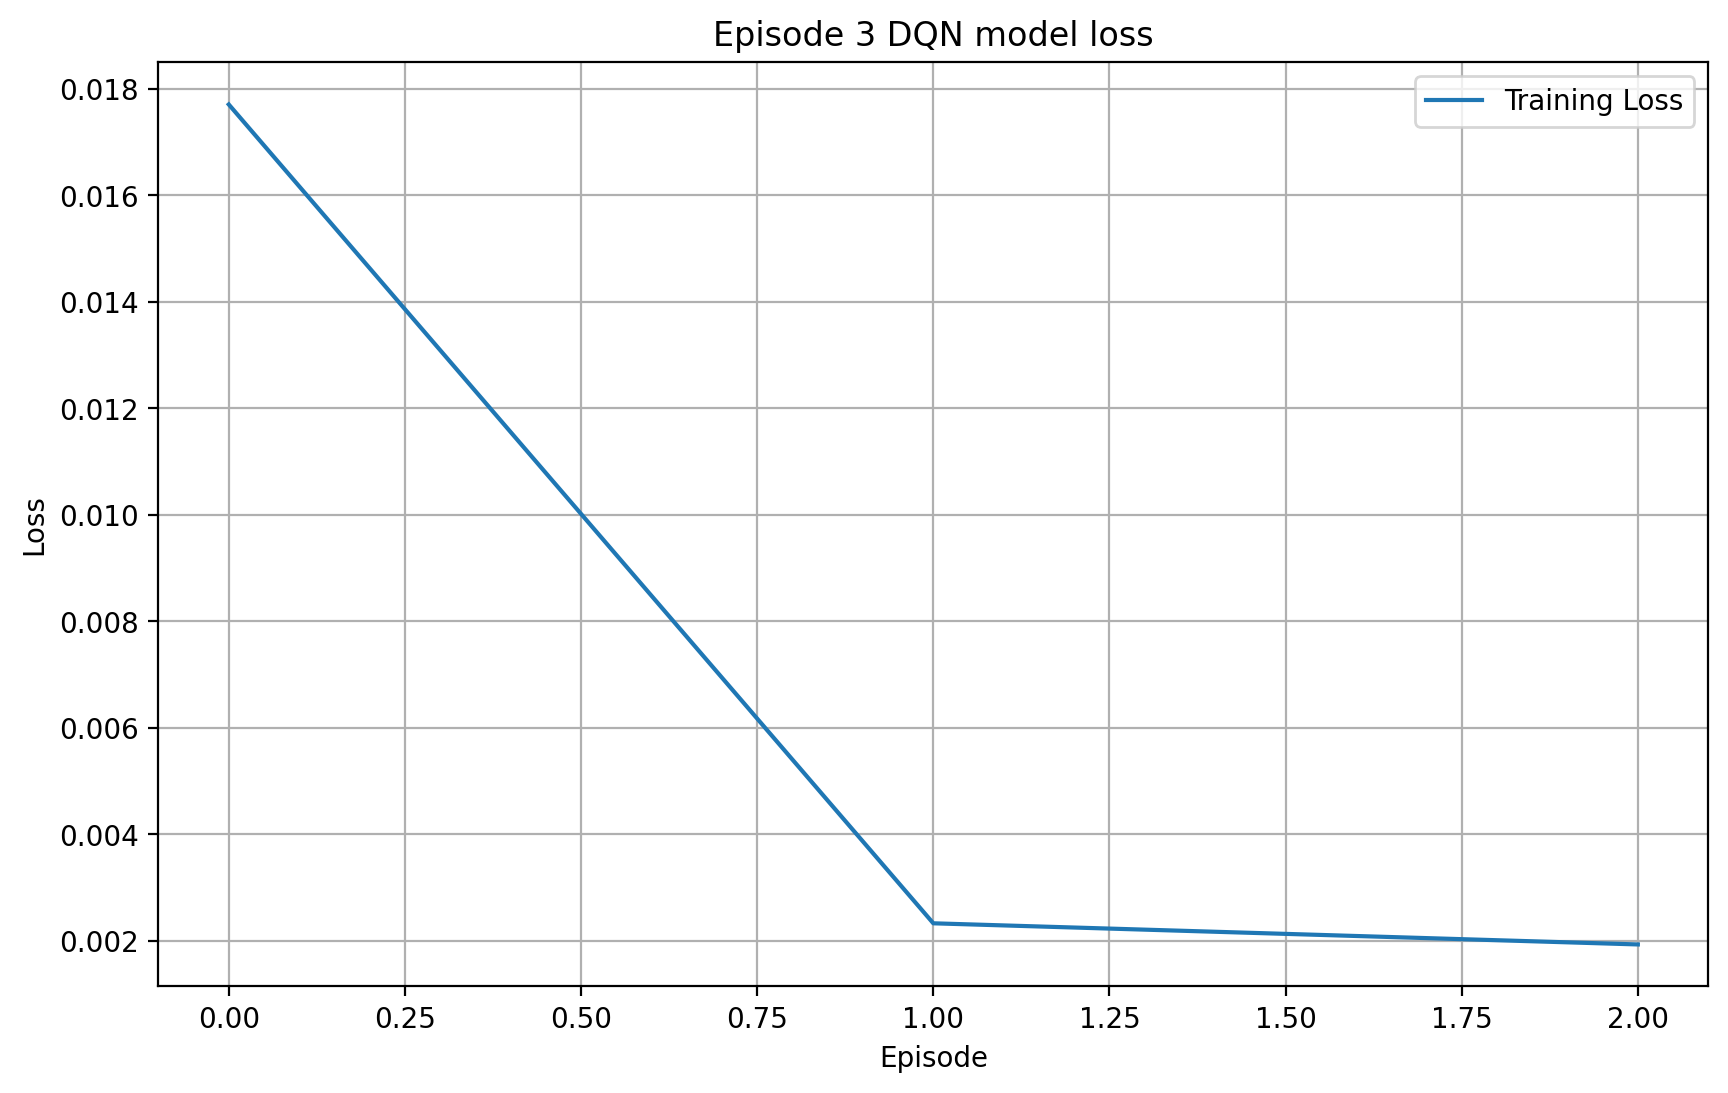

Episode 3/3 | Max Average Score: 9.14


In [20]:
scores, losses = dqn(
    env,
    agent,
    n_episodes=3,
    window=1,
    max_t=train_df.shape[0],
    epsilon=1.0,
    eps_min=0.01,
    eps_decay=0.995,
)

# 5. Test the trained model 
Finally, we get to test our trained model to see how well it performs in our test set. Using the training loop above, define a method to run our trained model on our X_test dataset. 

## Define Parameters
Some test parameters are defined for you below. Fill out the missing data. If you need a hint, look up at the training loop. 

In [21]:
test_env = Environment(test_df, window_size=1, verbose=True)

In [22]:
agent = Agent(
    test_env,
    test_mode=True,
    device=device,
)
agent.load(filename='checkpoint.pth')

/var/folders/f3/_6ts5bqd5s30t0mq76kjkdxc0000gn/T/ipykernel_57740/4026361148.py:170: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


### Run the Test
Run the test data through the trained model. Look at the training loop for a hint.

Buy: $7.25
Buy: $7.21
Buy: $7.30
Sell: $7.38 | Profit: $0.13
Sell: $7.39 | Profit: $0.18
Sell: $7.36 | Profit: $0.05
Buy: $7.16
Buy: $7.14
Buy: $7.35
Sell: $7.30 | Profit: $0.14
Buy: $7.29
Buy: $7.16
Buy: $7.14
Buy: $7.03
Buy: $7.01
Buy: $7.02
Buy: $6.90
Buy: $6.75
Buy: $6.78
Sell: $6.78 | Profit: $-0.36
Buy: $7.02
Sell: $6.95 | Profit: $-0.40
Buy: $7.03
Sell: $6.93 | Profit: $-0.36
Buy: $6.97
Buy: $6.85
Buy: $6.98
Sell: $7.08 | Profit: $-0.08
Sell: $7.16 | Profit: $0.02
Buy: $7.22
Buy: $7.47
Sell: $7.56 | Profit: $0.52
Sell: $7.47 | Profit: $0.46
Buy: $7.56
------------------------------------------
Total Profit: 0.30071163177490146
------------------------------------------
Sell: $7.53 | Profit: $0.51
------------------------------------------
Total Profit: 0.8096399307250968
------------------------------------------


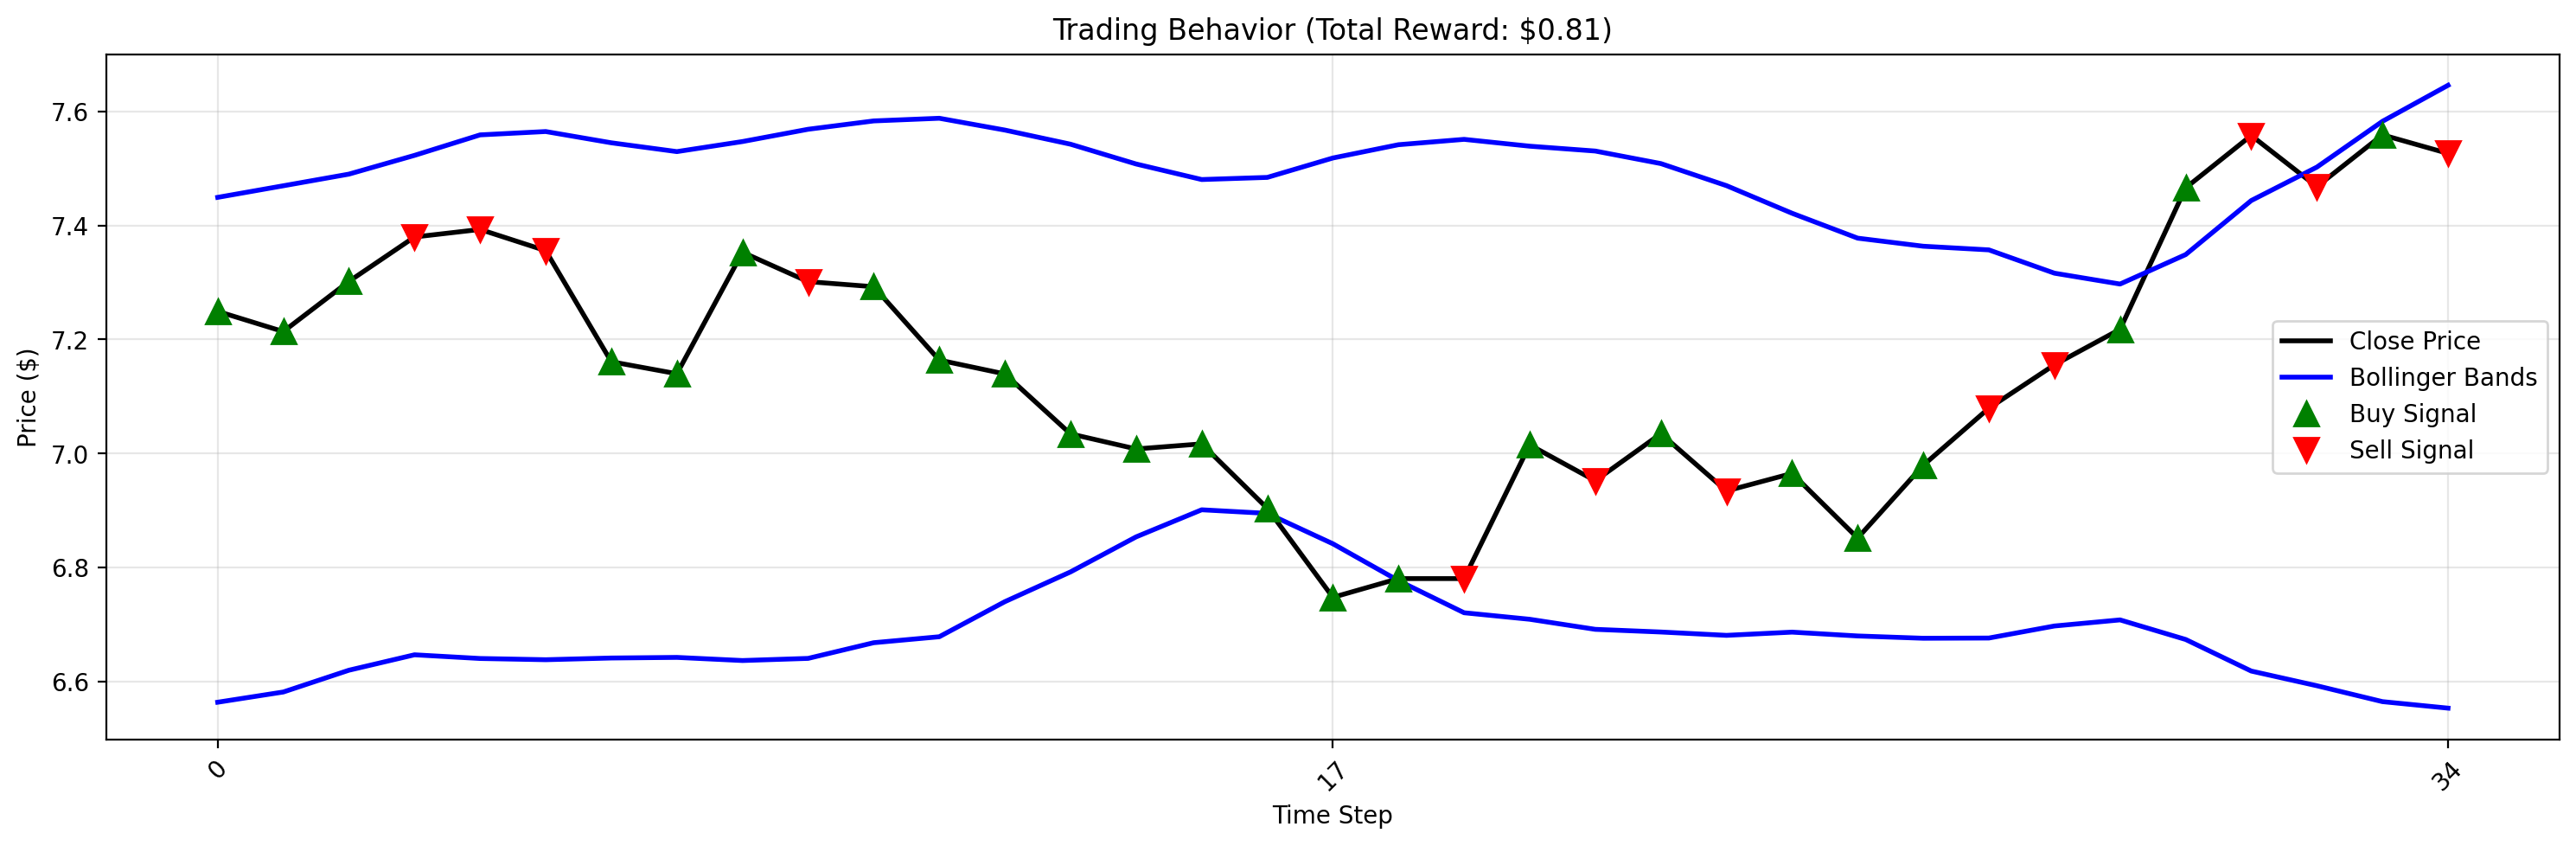

In [23]:
state = test_env.reset()
for t in range(test_df.shape[0]):
    action = agent.select_action(state)
    next_state, reward, done, info = test_env.step(action)
    
    state = next_state

    if done:
        print('------------------------------------------')
        print(f"Total Profit: {info['total_profit']}")
        print('------------------------------------------')
        
plot_behavior(test_env, info['states_buy'], info['states_sell'], info['total_profit'], train=False)